# Code for Fig. 1 and fig. S1 of
#### Yeager et al., 2021: An Outsized Role for the Labrador Sea in the Multidecadal Variability of the Atlantic Overturning Circulation, *Science Advances*.

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def open_POPdataset(x):
    ds = xr.open_dataset(x,decode_times=False)
    attrs=ds.time.attrs.copy()
    ds = ds.assign_coords(time=ds.time.values - 15)
    ds.time.attrs = attrs
    ds = xr.decode_cf(ds)
    return ds

In [3]:
datadir = '/glade/scratch/yeager/YeagerEA_ScienceAdvances_2021/'
f2_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.020001_050012.MOCsig.nc'
f2_lr = f'{datadir}/B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.000101_050012.MOCsig.nc'
f4_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.HMXL.March.natl.0200.0500.nc'
f4_lr = f'{datadir}/B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.HMXL.March.0200.0500.nc'
f5_hr = f'{datadir}/wmf.regions.POP_0p1.nc'
f5_hr_grid = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.HMXL.Annual.climatology.0200.0500.nc'
f5_lr = f'{datadir}/wmf.regions.POP_1deg.nc'

ds2_hr = open_POPdataset(f2_hr) 
ds2_lr = open_POPdataset(f2_lr)
ds4_hr = open_POPdataset(f4_hr)
ds4_lr = open_POPdataset(f4_lr)
ds5_hr = xr.open_dataset(f5_hr)
ds5_hr_grid = xr.open_dataset(f5_hr_grid)
ds5_lr = xr.open_dataset(f5_lr)
ds4_lr['WMF_REGION_MASK']= ds5_lr['WMF_REGION_MASK']
ds4_lr = util.pop_add_cyclic(ds4_lr)
#ds5_lr = util.pop_add_cyclic(ds5_lr)

In [4]:
# ARGO-based MLD
fargo = f'{datadir}/Argo_mixedlayers_monthlyclim_12112019.nc'
ds_argo = xr.open_dataset(fargo)
argomldann = ds_argo.mld_dt_mean.mean('iMONTH')
argomldmar = ds_argo.mld_dt_mean.isel(iMONTH=2)
argolat = ds_argo.lat
argolon = ds_argo.lon

In [5]:
# MLD Mean and StdDev
hrmldmar = ds4_hr.HMXL
hrmldmar = hrmldmar.where(hrmldmar>-1)/100.
hrmldmean = hrmldmar.mean('time')
lrmldmar = ds4_lr.HMXL/100.
lrmldmean = lrmldmar.mean('time')

## Select 20-year MLD climatologies 

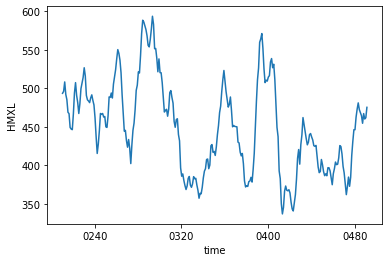

In [6]:
tmp = hrmldmar.isel(nlon=slice(200,300)).isel(nlat=slice(200,300)).mean('nlon').mean('nlat')
tmp.rolling(time=20,center=True).mean().plot();

In [7]:
hrmldmean1 = hrmldmar.sel(time=slice('0403-01','0422-12')).mean('time')

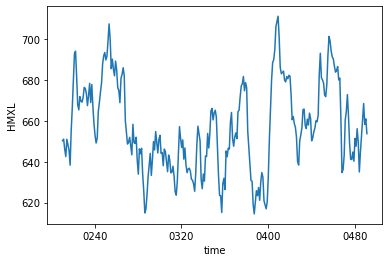

In [8]:
tmp = lrmldmar.isel(nlon=slice(158,175)).isel(nlat=slice(350,365)).mean('nlon').mean('nlat')
tmp.rolling(time=20,center=True).mean().plot();

In [9]:
lrmldmean1 = lrmldmar.sel(time=slice('0381-01','0400-12')).mean('time')

## Compute Means and Anomalies

In [10]:
# Annual Means
ds2_hr_ann = ds2_hr.groupby('time.year').mean('time')
ds2_lr_ann = ds2_lr.groupby('time.year').mean('time')
ds2_hr_ann=ds2_hr_ann.rename({'year':'time'}).sel(time=slice(200,500))
ds2_lr_ann=ds2_lr_ann.rename({'year':'time'}).sel(time=slice(200,500))

# Annual Anomalies
ds2_lr_mean = ds2_lr_ann.mean('time')
ds2_lr_annanom = ds2_lr_ann - ds2_lr_mean
ds2_hr_mean = ds2_hr_ann.mean('time')
ds2_hr_annanom = ds2_hr_ann - ds2_hr_mean

hrmldanom = hrmldmar - hrmldmean
lrmldanom = lrmldmar - lrmldmean


In [11]:
# Detrended Anomalies
ds2_lr_annanom_dt = xr.apply_ufunc(signal.detrend, ds2_lr_annanom.fillna(0), kwargs={'axis': 0}).where(ds2_lr_annanom.notnull())
ds2_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds2_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds2_hr_annanom.notnull())
hrmldanom_dt = xr.apply_ufunc(signal.detrend, hrmldanom.fillna(0), kwargs={'axis': 0}).where(hrmldanom.notnull())
lrmldanom_dt = xr.apply_ufunc(signal.detrend, lrmldanom.fillna(0), kwargs={'axis': 0}).where(lrmldanom.notnull())

In [12]:
# 10-year butterworth low-pass filter
fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
nyquist = fs / 2          # 0.5 times the sampling frequency
cutoff = fs/10            # 10-year cutoff frequency
cutoff = cutoff/nyquist   # as fraction of nyquist  
print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
filtb, filta = signal.butter(4, cutoff, 'lowpass')

cutoff=  10.0  years


In [13]:
# Low-Pass (lp) anomalies:
ds2_lr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds2_lr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds2_lr_annanom_dt.notnull())
ds2_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds2_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds2_hr_annanom_dt.notnull())
hrmld_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, hrmldanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(hrmldanom_dt.notnull())
lrmld_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, lrmldanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(lrmldanom_dt.notnull())


In [14]:
# Detrended, filtered Std Dev:
ds2_lr_lpdtstd = ds2_lr_lpanom_dt.std('time')
ds2_hr_lpdtstd = ds2_hr_lpanom_dt.std('time')
hrmld_lpdtstd = hrmld_lpanom_dt.std('time')
lrmld_lpdtstd = lrmld_lpanom_dt.std('time')

### Compute region lines

In [15]:
# Get Line Arrays
lrtlat = ds4_lr.TLAT
lrtlon = xr.where(ds4_lr.TLONG>180.,ds4_lr.TLONG-360.,ds4_lr.TLONG)
hrtlat = ds4_hr.TLAT
hrtlon = xr.where(ds4_hr.TLONG>180.,ds4_hr.TLONG-360.,ds4_hr.TLONG)

lrmsk = ds4_lr.WMF_REGION_MASK
lrmskw = lrmsk.roll(nlon=1,roll_coords=False)
lrmske = lrmsk.roll(nlon=-1,roll_coords=False)
lrmskn = lrmsk.shift(nlat=-1)
lrmsks = lrmsk.shift(nlat=1)
lrmskne = lrmske.shift(nlat=-1)
lrmsknw = lrmskw.shift(nlat=-1)

lrtlat_osnw = lrtlat.where((lrmsk==10) & ((lrmskn==4) | (lrmskw==4))).values.flatten()
lrtlat_osnw = lrtlat_osnw[~np.isnan(lrtlat_osnw)]
lrtlon_osnw = lrtlon.where((lrmsk==10) & ((lrmskn==4) | (lrmskw==4))).values.flatten()
lrtlon_osnw = lrtlon_osnw[~np.isnan(lrtlon_osnw)]
lrtlat_osne = lrtlat.where((lrmsk==10) & ((lrmskn==3)&(lrmsks==2))).values.flatten()
lrtlat_osne = lrtlat_osne[~np.isnan(lrtlat_osne)]
lrtlon_osne = lrtlon.where((lrmsk==10) & ((lrmskn==3)&(lrmsks==2))).values.flatten()
lrtlon_osne = lrtlon_osne[~np.isnan(lrtlon_osne)]
lrtlat_gsr = lrtlat.where((lrmsk==11)).values.flatten()
lrtlat_gsr = lrtlat_gsr[~np.isnan(lrtlat_gsr)]
lrtlon_gsr = lrtlon.where((lrmsk==11)).values.flatten()
lrtlon_gsr = lrtlon_gsr[~np.isnan(lrtlon_gsr)]
lrtlat_spg = lrtlat.where((lrmsk==2) & (lrmskw==1)).values.flatten()
lrtlat_spg = lrtlat_spg[~np.isnan(lrtlat_spg)]
lrtlon_spg = lrtlon.where((lrmsk==2) & (lrmskw==1)).values.flatten()
lrtlon_spg = lrtlon_spg[~np.isnan(lrtlon_spg)]
lrtlat_arc = lrtlat.where((lrmsk==5) & ((lrmskn==6) | (lrmske==6))).values.flatten()
lrtlat_arc = lrtlat_arc[~np.isnan(lrtlat_arc)]
lrtlon_arc = lrtlon.where((lrmsk==5) & ((lrmskn==6) | (lrmske==6))).values.flatten()
lrtlon_arc = lrtlon_arc[~np.isnan(lrtlon_arc)]


hrmsk = ds5_hr.WMF_REGION_MASK
hrtlatglb = ds5_hr_grid.TLAT
hrtlonglb = xr.where(ds5_hr_grid.TLONG>180.,ds5_hr_grid.TLONG-360.,ds5_hr_grid.TLONG)
hrmskw = hrmsk.roll(nlon=1,roll_coords=False)
hrmske = hrmsk.roll(nlon=-1,roll_coords=False)
hrmskn = hrmsk.shift(nlat=-1)
hrmsks = hrmsk.shift(nlat=1)
hrmskne = hrmske.shift(nlat=-1)
hrmsknw = hrmskw.shift(nlat=-1)

hrtlat_osnw = hrtlatglb.where((hrmsk==10) & ((hrmskn==4) | (hrmskw==4))).values.flatten()
hrtlat_osnw = hrtlat_osnw[~np.isnan(hrtlat_osnw)]
hrtlon_osnw = hrtlonglb.where((hrmsk==10) & ((hrmskn==4) | (hrmskw==4))).values.flatten()
hrtlon_osnw = hrtlon_osnw[~np.isnan(hrtlon_osnw)]
hrtlat_osne = hrtlatglb.where((hrmsk==10) & ((hrmskn==3)&(hrmsks==2))).values.flatten()
hrtlat_osne = hrtlat_osne[~np.isnan(hrtlat_osne)]
hrtlon_osne = hrtlonglb.where((hrmsk==10) & ((hrmskn==3)&(hrmsks==2))).values.flatten()
hrtlon_osne = hrtlon_osne[~np.isnan(hrtlon_osne)]
hrtlat_gsr = hrtlatglb.where((hrmsk==11)).values.flatten()
hrtlat_gsr = hrtlat_gsr[~np.isnan(hrtlat_gsr)]
hrtlon_gsr = hrtlonglb.where((hrmsk==11)).values.flatten()
hrtlon_gsr = hrtlon_gsr[~np.isnan(hrtlon_gsr)]
hrtlat_spg = hrtlatglb.where((hrmsk==2) & (hrmskw==1)).values.flatten()
hrtlat_spg = hrtlat_spg[~np.isnan(hrtlat_spg)]
hrtlon_spg = hrtlonglb.where((hrmsk==2) & (hrmskw==1)).values.flatten()
hrtlon_spg = hrtlon_spg[~np.isnan(hrtlon_spg)]
hrtlat_arc = hrtlatglb.where((hrmsk==5) & ((hrmskn==6) | (hrmske==6))).values.flatten()
hrtlat_arc = hrtlat_arc[~np.isnan(hrtlat_arc)]
hrtlon_arc = hrtlonglb.where((hrmsk==5) & ((hrmskn==6) | (hrmske==6))).values.flatten()
hrtlon_arc = hrtlon_arc[~np.isnan(hrtlon_arc)]



# Fig 1

<ipython-input-16-c29e461b4128>:108: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cntr1, cax=cbar_ax1, label='m', extend='max')
<ipython-input-16-c29e461b4128>:110: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cntr4, cax=cbar_ax2, label='m', extend='max')
<ipython-input-16-c29e461b4128>:112: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cntr7a1, cax=cbar_ax3, label='Sv', extend='max')


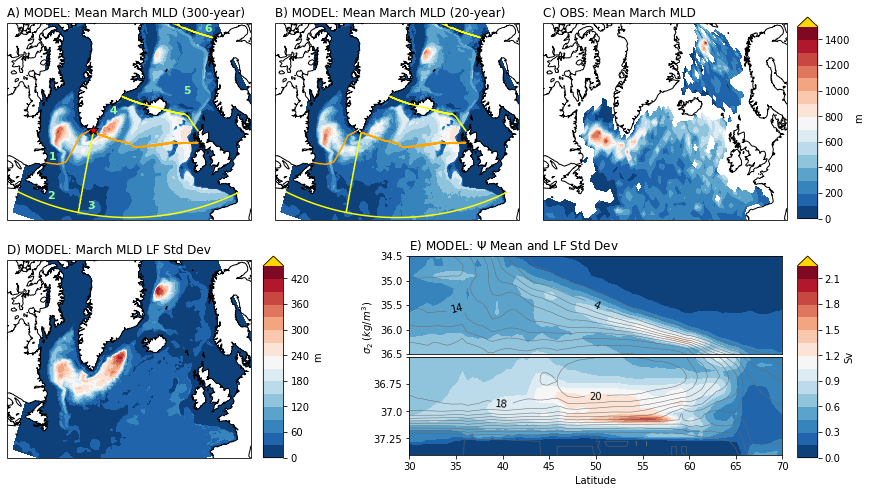

In [16]:
merid45_lon = np.arange(-60,0,0.5)
merid45_lat = merid45_lon.copy()
merid45_lat[:] = 45.

# MLD Mean & Std Dev
central_lon, central_lat = -30, 60
extent = [-60, 0, 39, 80]
mnlevs = np.arange(0,16,1)*100.
sdlevs = np.arange(0,16,1)*30.
reglevs = [0,1,2,3,4,5,6]
fontsize=12

textlon = np.array([-55.,-52.,-41.,-38.,-5,25])
textlat = np.array([53.,46., 46.,64,66,73])
textstr = ('1', '2','3','4','5','6')

#colmap = copy.copy(plt.cm.bwr)
colmap = copy.copy(plt.cm.RdBu_r)
#colmap = copy.copy(plt.cm.seismic)
overclr = 'gold'
lineclr = 'yellow'
lineclr2 = 'orange'

# Create projection:
proj = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(14, 8))
spec = fig.add_gridspec(ncols=6, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0:2], projection=proj)
ax2 = fig.add_subplot(spec[0, 2:4], projection=proj)
ax3 = fig.add_subplot(spec[0, 4:], projection=proj)
ax4 = fig.add_subplot(spec[1, 0:2], projection=proj)


ax1.set_title('A) MODEL: Mean March MLD (300-year)',fontsize=fontsize, loc='left')
cntr1 = ax1.contourf(hrtlon, hrtlat, hrmldmean, levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='max')
cntr1a = ax1.plot(hrtlon_osnw, hrtlat_osnw, color=lineclr2,transform=ccrs.PlateCarree())
cntr1b = ax1.plot(hrtlon_osne, hrtlat_osne, color=lineclr2,transform=ccrs.PlateCarree())
cntr1c = ax1.plot(hrtlon_gsr, hrtlat_gsr, color=lineclr,transform=ccrs.PlateCarree())
cntr1d = ax1.plot(merid45_lon, merid45_lat, color=lineclr,transform=ccrs.PlateCarree())
cntr1e = ax1.plot(hrtlon_spg, hrtlat_spg, color=lineclr,transform=ccrs.PlateCarree())
cntr1f = ax1.plot(hrtlon_arc, hrtlat_arc,color=lineclr,transform=ccrs.PlateCarree())
marker1 = ax1.plot(-43.5, 60.5,color='r',marker='*',ms=10,markeredgecolor='k',transform=ccrs.PlateCarree())
for i in range(textlon.size):
    ax1.text(textlon[i],textlat[i], textstr[i], transform=ccrs.PlateCarree(),color='palegreen',fontsize=11,weight='bold')
cntr1.cmap.set_over(overclr)
ax1.coastlines()
ax1.set_extent(extent)

ax2.set_title('B) MODEL: Mean March MLD (20-year)',fontsize=fontsize, loc='left')
cntr2 = ax2.contourf(hrtlon, hrtlat, hrmldmean1, levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='max')
cntr2a = ax2.plot(hrtlon_osnw, hrtlat_osnw, color=lineclr2,transform=ccrs.PlateCarree())
cntr2b = ax2.plot(hrtlon_osne, hrtlat_osne, color=lineclr2,transform=ccrs.PlateCarree())
cntr2c = ax2.plot(hrtlon_gsr, hrtlat_gsr, color=lineclr,transform=ccrs.PlateCarree())
cntr2d = ax2.plot(merid45_lon, merid45_lat, color=lineclr,transform=ccrs.PlateCarree())
cntr2e = ax2.plot(hrtlon_spg, hrtlat_spg, color=lineclr,transform=ccrs.PlateCarree())
cntr2f = ax2.plot(hrtlon_arc, hrtlat_arc,color=lineclr,transform=ccrs.PlateCarree())
cntr2.cmap.set_over(overclr)
ax2.coastlines()
ax2.set_extent(extent)

ax3.set_title('C) OBS: Mean March MLD',fontsize=fontsize, loc='left')
cntr3 = ax3.contourf(argolon, argolat, argomldmar, levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='max')
cntr3.cmap.set_over(overclr)
ax3.coastlines()
ax3.set_extent(extent)

ax4.set_title('D) MODEL: March MLD LF Std Dev',fontsize=fontsize, loc='left')
cntr4 = ax4.contourf(hrtlon, hrtlat, hrmld_lpdtstd, levels=sdlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='max')
cntr4.cmap.set_over(overclr)
ax4.coastlines()
ax4.set_extent(extent)

contcolor = 'dimgrey'
mnlevs = np.arange(0,17,1)*2. - 4.
sdlevs = np.arange(0,16,1)*0.15
ax7b = fig.add_axes([0.525, 0.13, 0.37, 0.17])
ax7a = fig.add_axes([0.525, 0.305, 0.37, 0.17])
fmt = '%2.0i'
ax7a.set_title(r'E) MODEL: $\Psi$ Mean and LF Std Dev',fontsize=fontsize, loc='left')
work7a = ds2_hr_lpdtstd.MOCsig.isel(transport_reg=1).isel(moc_comp=0)
work7b = ds2_hr_mean.MOCsig.isel(transport_reg=1).isel(moc_comp=0)
cntr7a1 = ax7a.contourf(work7a.lat_aux_grid, work7a.moc_s, work7a, levels=sdlevs, cmap=colmap, extend='max')
cntr7a2 = ax7a.contour(work7b.lat_aux_grid, work7b.moc_s, work7b,levels=mnlevs, linewidths=0.5, colors=contcolor)
cntr7a1.cmap.set_over(overclr)
ax7a.set_ylim(36.5, 34.5)
ax7a.set_xlim(30, 70)
ax7a.set_ylabel(r'$\sigma_2\; (kg/m^{3})$',loc='bottom')
ax7a.set_xticklabels([])
ax7a.set_xticks([])
#ax7a.plot([55,55],[36.25,35.75],c='k')
clabs = ((35,35.5),(50,35.5))
ax7a.clabel(cntr7a2, inline=True, fontsize=10, colors='k',fmt=fmt, manual=clabs)

cntr7b1 = ax7b.contourf(work7a.lat_aux_grid, work7a.moc_s, work7a, levels=sdlevs, cmap=colmap, extend='max')
cntr7b2 = ax7b.contour(work7b.lat_aux_grid, work7b.moc_s, work7b,levels=mnlevs, linewidths=0.5, colors=contcolor)
cntr7b1.cmap.set_over(overclr)
ax7b.set_ylim(37.4, 36.5)
ax7b.set_xlim(30, 70)
ax7b.set_xlabel('Latitude')
ax7b.set_yticks([37.25,37.0,36.75,36.5])
ax7b.set_yticklabels(['37.25','37.0','36.75',''])
#ax7b.plot([55,55],[37.0,37.25],c='k')
clabs = ((40,36.87),(50,36.75))
ax7b.clabel(cntr7b2, inline=True, fontsize=10, colors='k',fmt=fmt, manual=clabs)

fig.subplots_adjust(right=0.9)
cbar_ax1 = fig.add_axes([0.91, 0.54, 0.02, 0.35])
fig.colorbar(cntr1, cax=cbar_ax1, label='m', extend='max')
cbar_ax2 = fig.add_axes([0.38, 0.125, 0.02, 0.35])
fig.colorbar(cntr4, cax=cbar_ax2, label='m', extend='max')
cbar_ax3 = fig.add_axes([0.91, 0.125, 0.02, 0.35])
fig.colorbar(cntr7a1, cax=cbar_ax3, label='Sv', extend='max')

plt.savefig('Fig_1.pdf')

# fig S1

<ipython-input-18-19082d1a0da6>:108: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cntr1, cax=cbar_ax1, label='m', extend='max')
<ipython-input-18-19082d1a0da6>:110: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cntr4, cax=cbar_ax2, label='m', extend='max')
<ipython-input-18-19082d1a0da6>:112: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cntr7a1, cax=cbar_ax3, label='Sv', extend='max')


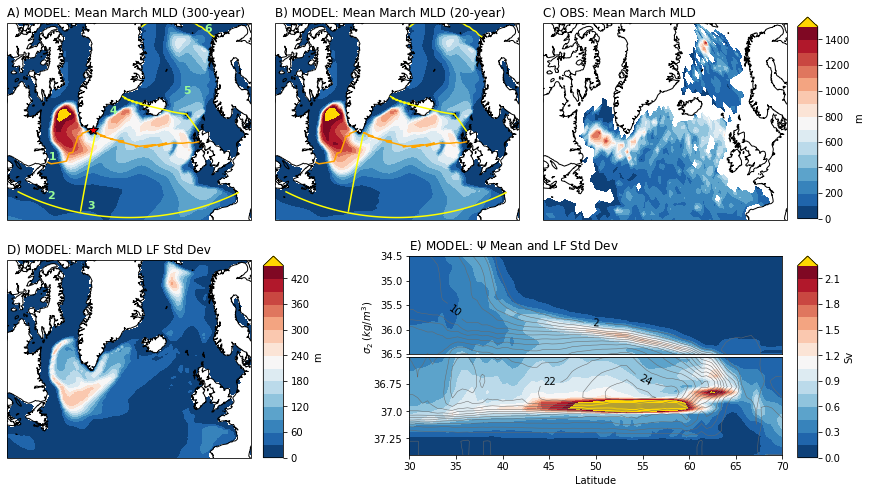

In [18]:
merid45_lon = np.arange(-60,0,0.5)
merid45_lat = merid45_lon.copy()
merid45_lat[:] = 45.

# MLD Mean & Std Dev
central_lon, central_lat = -30, 60
extent = [-60, 0, 39, 80]
mnlevs = np.arange(0,16,1)*100.
sdlevs = np.arange(0,16,1)*30.
reglevs = [0,1,2,3,4,5,6]
fontsize=12

textlon = np.array([-55.,-52.,-41.,-38.,-5,25])
textlat = np.array([53.,46., 46.,64,66,73])
textstr = ('1', '2','3','4','5','6')

#colmap = copy.copy(plt.cm.bwr)
colmap = copy.copy(plt.cm.RdBu_r)
overclr = 'gold'
lineclr = 'yellow'
lineclr2 = 'orange'

# Create projection:
proj = ccrs.Orthographic(central_lon, central_lat)

fig = plt.figure(figsize=(14, 8))
spec = fig.add_gridspec(ncols=6, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0:2], projection=proj)
ax2 = fig.add_subplot(spec[0, 2:4], projection=proj)
ax3 = fig.add_subplot(spec[0, 4:], projection=proj)
ax4 = fig.add_subplot(spec[1, 0:2], projection=proj)


ax1.set_title('A) MODEL: Mean March MLD (300-year)',fontsize=fontsize, loc='left')
cntr1 = ax1.contourf(lrtlon, lrtlat, lrmldmean, levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='max')
cntr1a = ax1.plot(lrtlon_osnw, lrtlat_osnw, color=lineclr2,transform=ccrs.PlateCarree())
cntr1b = ax1.plot(lrtlon_osne, lrtlat_osne, color=lineclr2,transform=ccrs.PlateCarree())
cntr1c = ax1.plot(lrtlon_gsr, lrtlat_gsr, color=lineclr,transform=ccrs.PlateCarree())
cntr1d = ax1.plot(merid45_lon, merid45_lat, color=lineclr,transform=ccrs.PlateCarree())
cntr1e = ax1.plot(lrtlon_spg, lrtlat_spg, color=lineclr,transform=ccrs.PlateCarree())
cntr1f = ax1.plot(lrtlon_arc, lrtlat_arc,color=lineclr,transform=ccrs.PlateCarree())
marker1 = ax1.plot(-43.5, 60.5,color='r',marker='*',ms=10,markeredgecolor='k',transform=ccrs.PlateCarree())
for i in range(textlon.size):
    ax1.text(textlon[i],textlat[i], textstr[i], transform=ccrs.PlateCarree(),color='palegreen',fontsize=11,weight='bold')
#ax1.text(textlon[1],textlat[1], textstr[1], transform=ccrs.PlateCarree(),color='w',weight='bold')
#ax1.text(textlon[5],textlat[5], textstr[5], transform=ccrs.PlateCarree(),color='w',weight='bold')
cntr1.cmap.set_over(overclr)
ax1.coastlines()
ax1.set_extent(extent)

ax2.set_title('B) MODEL: Mean March MLD (20-year)',fontsize=fontsize, loc='left')
cntr2 = ax2.contourf(lrtlon, lrtlat, lrmldmean1, levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='max')
cntr2a = ax2.plot(lrtlon_osnw, lrtlat_osnw, color=lineclr2,transform=ccrs.PlateCarree())
cntr2b = ax2.plot(lrtlon_osne, lrtlat_osne, color=lineclr2,transform=ccrs.PlateCarree())
cntr2c = ax2.plot(lrtlon_gsr, lrtlat_gsr, color=lineclr,transform=ccrs.PlateCarree())
cntr2d = ax2.plot(merid45_lon, merid45_lat, color=lineclr,transform=ccrs.PlateCarree())
cntr2e = ax2.plot(lrtlon_spg, lrtlat_spg, color=lineclr,transform=ccrs.PlateCarree())
cntr2f = ax2.plot(lrtlon_arc, lrtlat_arc,color=lineclr,transform=ccrs.PlateCarree())
cntr2.cmap.set_over(overclr)
ax2.coastlines()
ax2.set_extent(extent)

ax3.set_title('C) OBS: Mean March MLD',fontsize=fontsize, loc='left')
cntr3 = ax3.contourf(argolon, argolat, argomldmar, levels=mnlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='max')
cntr3.cmap.set_over(overclr)
ax3.coastlines()
ax3.set_extent(extent)

ax4.set_title('D) MODEL: March MLD LF Std Dev',fontsize=fontsize, loc='left')
cntr4 = ax4.contourf(lrtlon, lrtlat, lrmld_lpdtstd, levels=sdlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='max')
cntr4.cmap.set_over(overclr)
ax4.coastlines()
ax4.set_extent(extent)

contcolor = 'dimgrey'
mnlevs = np.arange(0,17,1)*2. - 4.
sdlevs = np.arange(0,16,1)*0.15
ax7b = fig.add_axes([0.525, 0.13, 0.37, 0.17])
ax7a = fig.add_axes([0.525, 0.305, 0.37, 0.17])
fmt = '%2.0i'
ax7a.set_title(r'E) MODEL: $\Psi$ Mean and LF Std Dev',fontsize=fontsize, loc='left')
work7a = ds2_lr_lpdtstd.MOCsig.isel(transport_reg=1).isel(moc_comp=0)
work7b = ds2_lr_mean.MOCsig.isel(transport_reg=1).isel(moc_comp=0)
cntr7a1 = ax7a.contourf(work7a.lat_aux_grid, work7a.moc_s, work7a, levels=sdlevs, cmap=colmap, extend='max')
cntr7a2 = ax7a.contour(work7b.lat_aux_grid, work7b.moc_s, work7b,levels=mnlevs, linewidths=0.5, colors=contcolor)
cntr7a1.cmap.set_over(overclr)
ax7a.set_ylim(36.5, 34.5)
ax7a.set_xlim(30, 70)
ax7a.set_ylabel(r'$\sigma_2\; (kg/m^{3})$',loc='bottom')
ax7a.set_xticklabels([])
ax7a.set_xticks([])
clabs = ((35,35.5),(50,35.5))
ax7a.clabel(cntr7a2, inline=True, fontsize=10, colors='k',fmt=fmt, manual=clabs)

cntr7b1 = ax7b.contourf(work7a.lat_aux_grid, work7a.moc_s, work7a, levels=sdlevs, cmap=colmap, extend='max')
cntr7b2 = ax7b.contour(work7b.lat_aux_grid, work7b.moc_s, work7b,levels=mnlevs, linewidths=0.5, colors=contcolor)
cntr7b1.cmap.set_over(overclr)
ax7b.set_ylim(37.4, 36.5)
ax7b.set_xlim(30, 70)
ax7b.set_xlabel('Latitude')
ax7b.set_yticks([37.25,37.0,36.75,36.5])
ax7b.set_yticklabels(['37.25','37.0','36.75',''])
clabs = ((45,36.75),(55,36.75))
ax7b.clabel(cntr7b2, inline=True, fontsize=10, colors='k',fmt=fmt, manual=clabs)

fig.subplots_adjust(right=0.9)
cbar_ax1 = fig.add_axes([0.91, 0.54, 0.02, 0.35])
fig.colorbar(cntr1, cax=cbar_ax1, label='m', extend='max')
cbar_ax2 = fig.add_axes([0.38, 0.125, 0.02, 0.35])
fig.colorbar(cntr4, cax=cbar_ax2, label='m', extend='max')
cbar_ax3 = fig.add_axes([0.91, 0.125, 0.02, 0.35])
fig.colorbar(cntr7a1, cax=cbar_ax3, label='Sv', extend='max')

plt.savefig('fig_S1.pdf')